# Introduction to the Project

#### ASL (American Sign Language) gesture recognition is a field that uses computer vision and machine learning to identify and interpret hand gestures used in ASL. This technology aims to facilitate communication between individuals who use ASL and those who do not, often by translating signs into text or speech. 

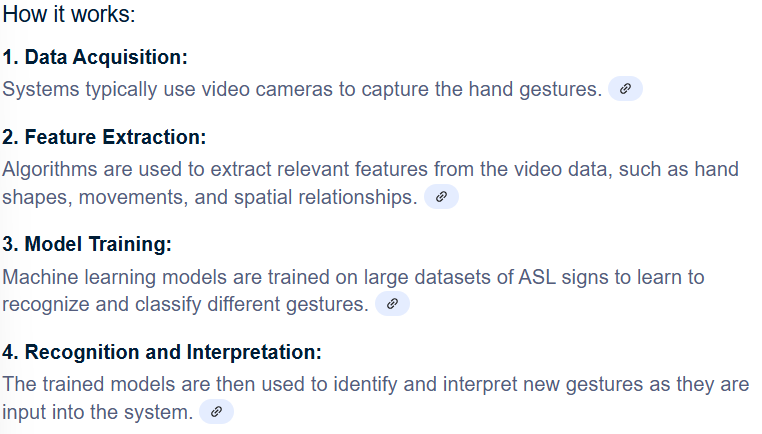

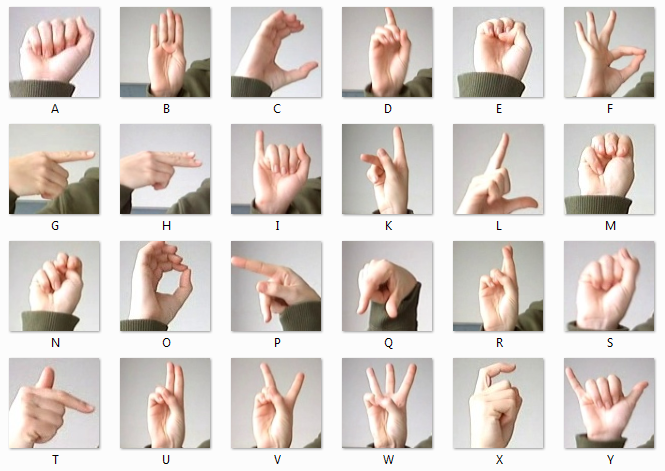

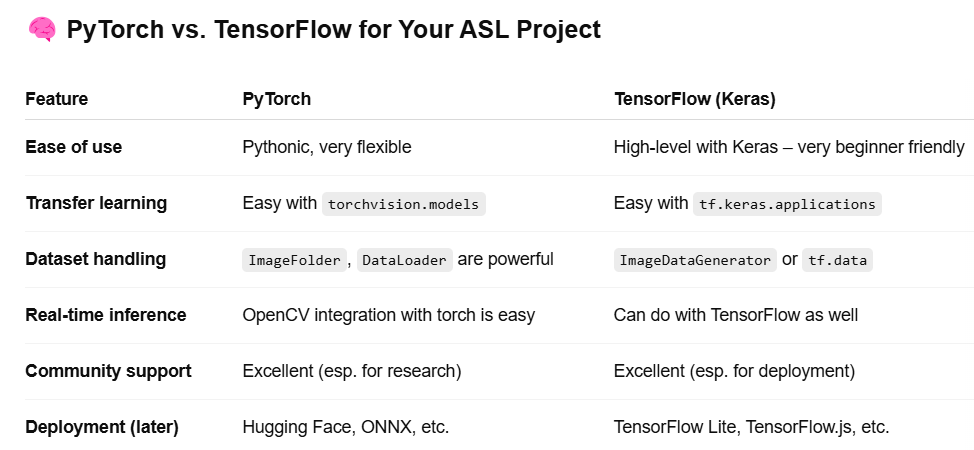

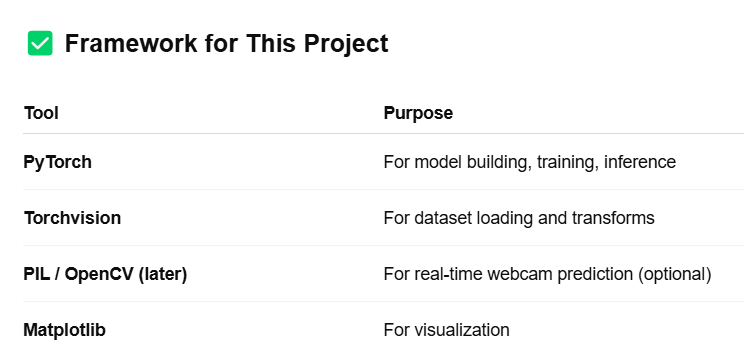

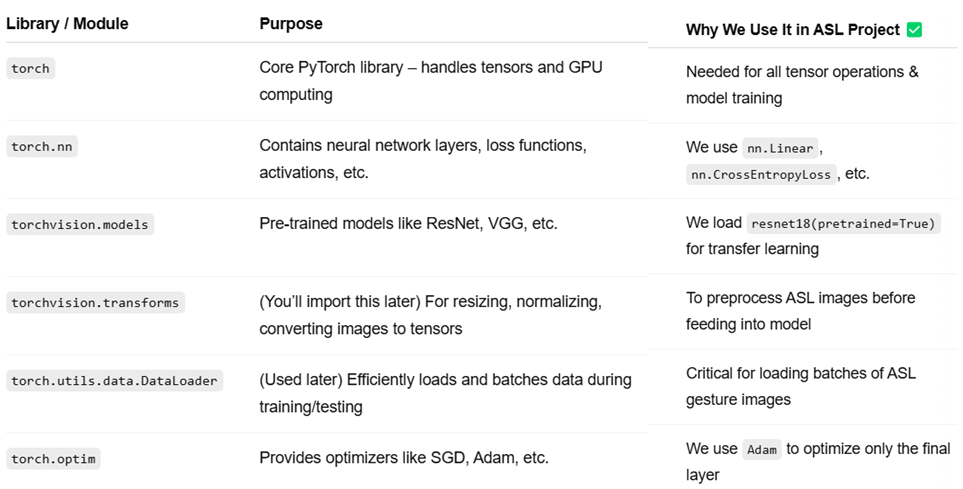

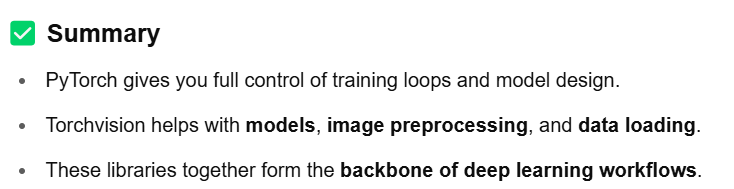

## Import Libraries

In [1]:
import os
import torch
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt  
from PIL import Image

## Data Import

In [5]:
# Set the dataset paths
train_path = 'dataset/asl_alphabet_train'
test_path = 'dataset/asl_alphabet_test'

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

asl_dataset = datasets.ImageFolder(root = train_path, transform=transform)
class_names = asl_dataset.classes

## Visualize Data

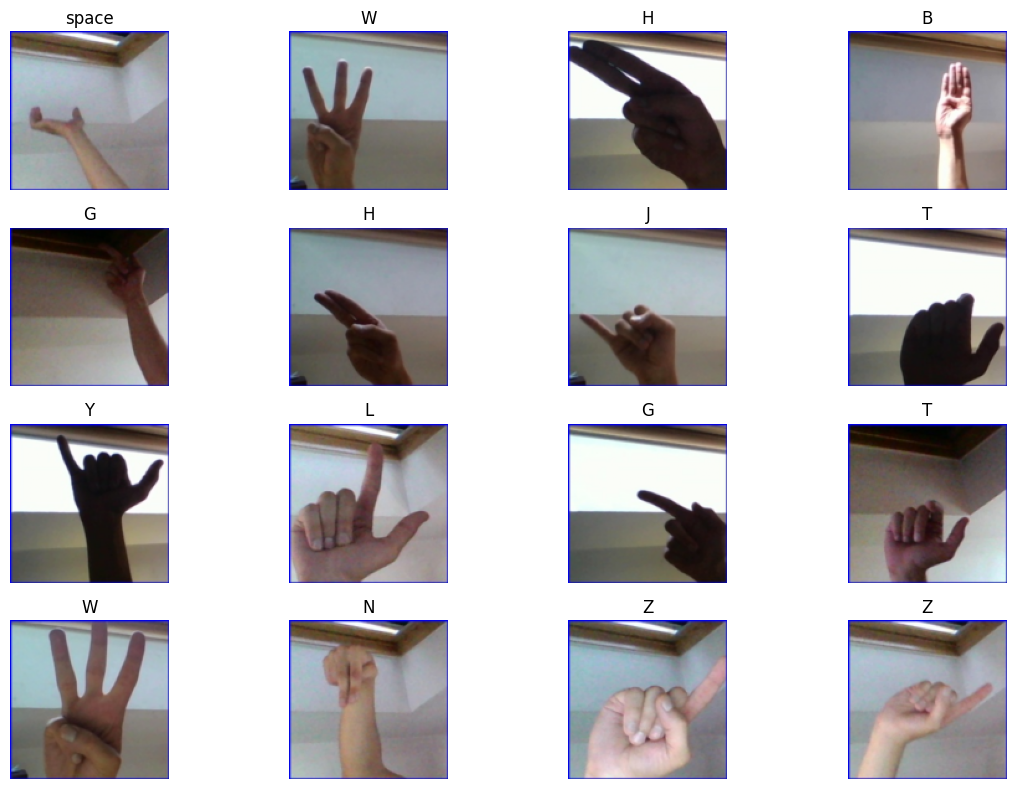

In [ ]:
data_loader =  DataLoader(asl_dataset, batch_size=16,shuffle=True)
images, labels = next(iter(data_loader))

def show_images(images, labels, class_name):
    plt.figure(figsize=(12,8))
    for i in range(len(images)):
        plt.subplot(4,4,i+1)
        img = images[i].permute(1,2,0)  # Convert from [C, H, W] → [H, W, C]
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
show_images(images,labels,class_names)

## Data Preprocessing 
## Split into Train and Validation

In [8]:
num_classes = len(class_names)
print(f'Total Classes: {num_classes}')
print(f'\nClasses: {class_names}')

train_size = int(0.8* len(asl_dataset))
val_size = len(asl_dataset) - train_size

train_dataset, val_dataset = random_split(asl_dataset, [train_size,val_size])

batch_size = 32

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)


Total Classes: 29

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


## Define a Custom CNN Model

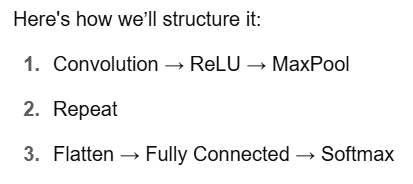

In [17]:
import torch.nn as nn   
import torch.nn.functional as F       

In [18]:
class ASL_CNN(nn.Module):
    def __init__(self, num_classes):
        super(ASL_CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)    # Input RGB image
        self.pool =  nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 256)    # After 3 pooling Layers (128x128 -> 16x16
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 128x128 -> 64x64
        x = self.pool(F.relu(self.conv2(x)))    # 64x64 -> 32x32
        x = self.pool(F.relu(self.conv3(x)))    # 32x32 -> 16x16
        x = x.view(-1,128*16*16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ASL_CNN(num_classes=num_classes).to(device)
print(model)

ASL_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Train the Model

In [20]:
import torch.optim as optim   

# CrossEntropy is suitable for multi class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer is commonly used and performs well
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [21]:
EPOCHS = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    
    # Train Running
    model.train()
    running_loss = 0.0
    correct = 0 
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
        
    # Validation Running
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/10] - Train Loss: 1.1012, Train Acc: 0.6422 | Val Loss: 0.2605, Val Acc: 0.9214
Epoch [2/10] - Train Loss: 0.2711, Train Acc: 0.9032 | Val Loss: 0.1030, Val Acc: 0.9648
Epoch [3/10] - Train Loss: 0.1568, Train Acc: 0.9451 | Val Loss: 0.0484, Val Acc: 0.9848
Epoch [4/10] - Train Loss: 0.1124, Train Acc: 0.9612 | Val Loss: 0.0364, Val Acc: 0.9884
Epoch [5/10] - Train Loss: 0.0885, Train Acc: 0.9696 | Val Loss: 0.0245, Val Acc: 0.9917
Epoch [6/10] - Train Loss: 0.0720, Train Acc: 0.9758 | Val Loss: 0.0183, Val Acc: 0.9939
Epoch [7/10] - Train Loss: 0.0603, Train Acc: 0.9797 | Val Loss: 0.0211, Val Acc: 0.9930
Epoch [8/10] - Train Loss: 0.0562, Train Acc: 0.9815 | Val Loss: 0.0139, Val Acc: 0.9957
Epoch [9/10] - Train Loss: 0.0496, Train Acc: 0.9834 | Val Loss: 0.0148, Val Acc: 0.9953
Epoch [10/10] - Train Loss: 0.0451, Train Acc: 0.9850 | Val Loss: 0.0124, Val Acc: 0.9963


## Plot Accuracy and Loss

In [22]:
import matplotlib.pyplot as plt 

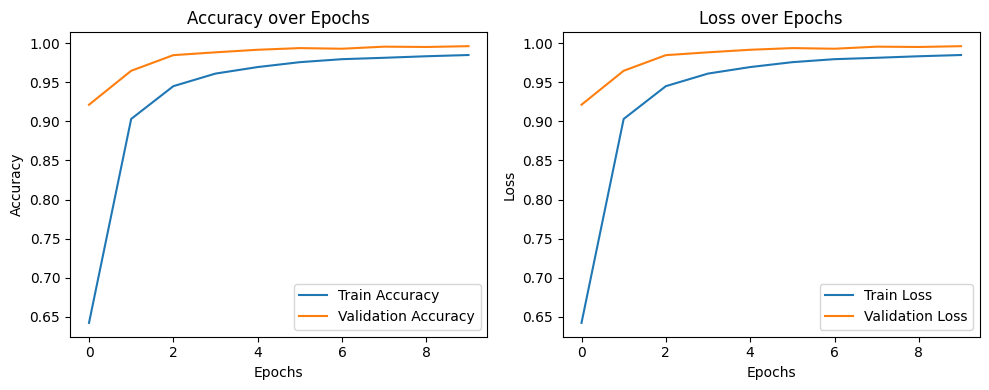

In [23]:
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Loss')
plt.plot(val_accuracies, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate the Model

In [37]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define the transformation for image preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Define your test dataset class to load images
class ASLTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = sorted([os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpg')])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]     # We return filename instead of label

# Define the path to your test images
test_dir = 'dataset/asl_alphabet_test'

# Load the test dataset and create a DataLoader
test_dataset = ASLTestDataset(root_dir=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the trained model (ensure it's on the correct device)
model = ASL_CNN(num_classes=len(class_names))  # Assuming your class_names is already defined
model.load_state_dict(torch.load('asl_customcnn_model.pth'))  # Load your model weights
model = model.to(device)

# Make predictions for each image in the test set
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        
        # Make prediction
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Get the predicted class
        predicted_class = class_names[predicted.item()]
        
        # Get the filename of the image
        filename = filenames[0]
        
        # Print the result
        print(f'{filename} -> Prediction: {predicted_class}')


dataset/asl_alphabet_test\A_test.jpg -> Prediction: A
dataset/asl_alphabet_test\B_test.jpg -> Prediction: B
dataset/asl_alphabet_test\C_test.jpg -> Prediction: C
dataset/asl_alphabet_test\D_test.jpg -> Prediction: D
dataset/asl_alphabet_test\E_test.jpg -> Prediction: E
dataset/asl_alphabet_test\F_test.jpg -> Prediction: F
dataset/asl_alphabet_test\G_test.jpg -> Prediction: G
dataset/asl_alphabet_test\H_test.jpg -> Prediction: H
dataset/asl_alphabet_test\I_test.jpg -> Prediction: I
dataset/asl_alphabet_test\J_test.jpg -> Prediction: J
dataset/asl_alphabet_test\K_test.jpg -> Prediction: K
dataset/asl_alphabet_test\L_test.jpg -> Prediction: L
dataset/asl_alphabet_test\M_test.jpg -> Prediction: M
dataset/asl_alphabet_test\N_test.jpg -> Prediction: N
dataset/asl_alphabet_test\O_test.jpg -> Prediction: O
dataset/asl_alphabet_test\P_test.jpg -> Prediction: P
dataset/asl_alphabet_test\Q_test.jpg -> Prediction: Q
dataset/asl_alphabet_test\R_test.jpg -> Prediction: R
dataset/asl_alphabet_test\S_

## Save the Model

In [38]:
torch.save(model.state_dict(), 'asl_customcnn_model.pth')

## Use Mediapipe to Train

## Use Transfer Learning Method

## Evaluate the Model

## Save the Model